<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  SVD en reconocimiento facial

En este caso-taller vamos a aplicar SVD para hacer reconocimiento facial. Esta aplicación se conoce como caras propias, o eigenfaces en inglés, y si bien es una forma rudimentaria de reconocimiento facial sus resultados pueden ser muy interesantes. El problema de las caras propias fue estudiado por primera vez por Sirovich y Kirby en 1987, ampliado en 1990 y su aplicación al reconocimiento facial automatizado fue presentado por Turk and Pentland en 1991.

En este taller vamos a utilizar la base de datos conocida como Caras Etiquetadas en la Naturaleza, o Labeled Faces in the Wild (LFW). Esta base es provista por la Universidad de Massachusetts Amherst para que la comunidad académica la utilice para la evaluación de modelos predictivos.

La base contiene más de 13.000 imágenes de rostros recopilados de la web y cada cara ha sido etiquetada con el nombre de la persona representada. Un subconjunto de 1.680 de las personas fotografiadas tienen dos o más fotos distintas en el conjunto de datos. 


 
#### Referencias

- G. B. Huang,  M. Ramesh, T. Berg, and E. Learned-Miller. Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments. University of Massachusetts, Amherst, Technical Report 07-49, October, 2007.

- M. Kirby and L. Sirovich. Application of the Karhunen-Loève procedure for the characterization of human faces. IEEE Transactions on Pattern Analysis and Machine Intelligence (PAMI), 12(1):103–108, 1990.

- L. Sirovich and M. Kirby. A low-dimensional procedure for the characterization of human faces. Journal of the Optical Society of America A, 4(3):519–524, 1987

- M. Turk and A. Pentland. Eigenfaces for recognition. Journal of Cognitive Neuroscience, 3(1):71–86, 1991.

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "Revisión por el compañero".

4. El archivo entregado debe poder ser ejecutado localmente por los pares. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos  en la misma ruta de acceso del cuaderno, por ejemplo: `data`.

## Desarrollo


### 1. Carga de datos 

Los datos pueden ser descargados directamente utilizando la librería `scikit-learn`, para ello cargue la base utilizando la función `fetch_lfw_people`. Esta función verificará si los datos están disponibles. De no estarlo, `scikit-learn` los descargará automáticamente desde el sitio web de la Universidad de Massachusetts. Descargue las imágenes para individuos que tengan al menos 25 imágenes y guárdelos en una carpeta llamada `data` usando esta función.

In [2]:
from sklearn.datasets import fetch_lfw_people
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import svd #pueden explorar con sklearn
from sklearn.decomposition import TruncatedSVD

In [3]:
# Utilice este espacio para escribir el código.


lfw_people = fetch_lfw_people(data_home = 'data', min_faces_per_person=25)
lfw_people.data.shape

(2588, 2914)

Lectura de datos

### 2.  Análisis preliminar 

Describa los contenidos de la base, tenga en cuenta que debe detallar los elementos, la dimensión de la base, y la dimensión de las imágenes. 

In [3]:
print(lfw_people.DESCR)

.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

    http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the OpenC

La informacion esta almacenada como diccionario en la cuales se tienen los elementos

- **data**: tiene la forma de n x f en donde:
    - **n** es la cantidad total de imagenes obtenidas por la carga de informacion
    - **f** es la imagen correspondiente al dato $n_i$ reformada de tal manera que queda como un vector 1 x k , donde k es igual a la multiplicacion de (h*w) donde h es la altura de la imagen y w es el ancho de la misma (ambas medidas en pixeles), k tambien se interpreta como el numero total de pixeles en la imagen

- **images**: tiene almacenados los datos en la forma n x 1, sin embargo este primer elemento es una matriz de la forma (h x w)

- **target**: array de tamaño n x 1 que contiene la codificacion numerica que indica de quien es la cara, para saber el nombre de  la persona es necesario cotejar los valores aca expuestos con los almacenados en la variable **target_names**

- **target_names**: array que contiene los nombres de las personas a las cuales corresponden las imagenes, en este caso se puede interpretar como que el elemento en la posicion **n** corresopnde al nombre de la persona cuyo codigo es igual a **n**

In [4]:
(n,k) = lfw_people["data"].shape
print("tamaño total de los datos: {n}".format(n=n))
print("tamaño del array con la imagen en formato plano (total de pixeles en la imagen): {k}".format(k=k))

tamaño total de los datos: 2588
tamaño del array con la imagen en formato plano (total de pixeles en la imagen): 2914


In [5]:
(n,h,w) = lfw_people["images"].shape
print("tamaño total de los datos: {n}".format(n=n))
print("altura de la imagen en píxeles: {h}".format(h=h))
print("ancho de la imagen en píxeles: {w}".format(w=w))
print("total de pixeles en la imagen: {t}".format(t=h*w))

tamaño total de los datos: 2588
altura de la imagen en píxeles: 62
ancho de la imagen en píxeles: 47
total de pixeles en la imagen: 2914


Como es de esperarse la multiplicacion de **h** y **w** es igual a el segundo componente del array **data** (2914)

a continuacion para tratar mejor los datos las variables relacionadas con el **target** se van a transformar a un dataframe

In [6]:
df_images = pd.DataFrame(lfw_people["data"])

target = lfw_people["target"]
target = pd.DataFrame(target, columns=['target'])
df_images = df_images.join(target)
df_images["target_name"] = df_images["target"].map(dict(enumerate(lfw_people["target_names"])))

print("numero de imagenes descargadas:{n}".format(n=df_images.shape[0]))
print("cantidad de personas con imagenes en el dataset: {p}".format(p=lfw_people["target_names"].shape[0]))

numero de imagenes descargadas:2588
cantidad de personas con imagenes en el dataset: 42


A continuación responda las siguientes preguntas: 

- ¿Cuál es la distribución de imágenes por individuos? 

target_name  George W Bush  Colin Powell  Tony Blair  Donald Rumsfeld  \
target                 530           236         144              121   

target_name  Gerhard Schroeder  Ariel Sharon  Hugo Chavez  Junichiro Koizumi  \
target                     109            77           71                 60   

target_name  Jean Chretien  John Ashcroft  ...  Recep Tayyip Erdogan  \
target                  55             53  ...                    30   

target_name  Guillermo Coria  Bill Clinton  Mahmoud Abbas  \
target                    30            29             29   

target_name  Juan Carlos Ferrero  Jack Straw  Ricardo Lagos  Rudolph Giuliani  \
target                        28          28             27                26   

target_name  Gray Davis  Tom Daschle  
target               26           25  

[1 rows x 42 columns]

target
count   42.000000
mean    61.619048
std     83.618749
min     25.000000
25%     31.000000
50%     38.000000
75%     52.000000
max    530.000000

<Axes: xlabel='target', ylabel='target_name'>

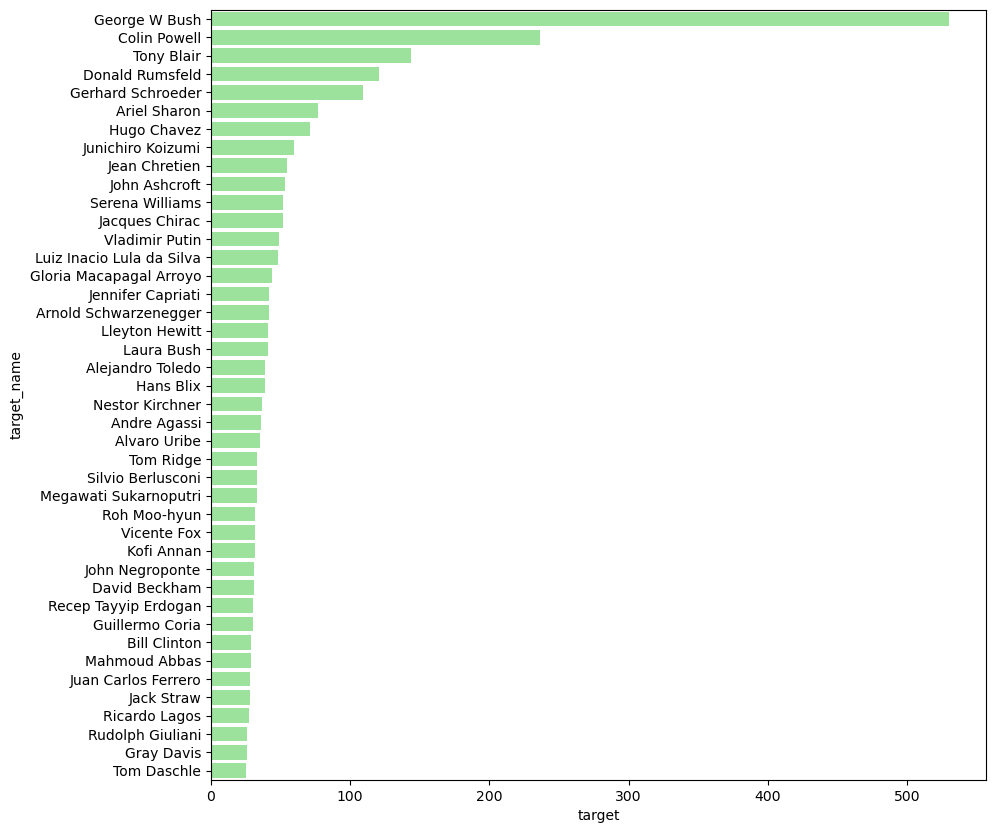

In [7]:
# Utilice este espacio para escribir el código.
gr_target = df_images.groupby("target_name")[["target"]].count().sort_values(by="target",ascending=False)
display(gr_target.T)
display(gr_target.describe())

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=gr_target.reset_index(),x="target", y="target_name", ax=ax, color="lightgreen")

Se tienen imagenes de 42 personas en todo el dataset, siendo George W Bush la persona con mas imagenes (530) y Tom Daschle la persona con menos imagenes (25).

La segunda tabla contiene la informacion de la distribucion de la cantidad de imagenes por persona siendo la mediana igual a 38, es decir el 50% de las personas de dataset tienen menos de 38 imagenes. El promedio es igual a approx 62 imagenes lo cual nos muestra que la cantidad de imagenes por persona no esta distribuida de forma uniforme o de forma normal

- ¿Cuántas imágenes pertenecen a Serena Williams? Grafíquelas 

In [8]:
nombre = "Serena Williams"
print("Cantidad de imagenes de {nom} : {n}".format(nom=nombre, n = gr_target.loc[nombre,"target"]))

Cantidad de imagenes de Serena Williams : 52


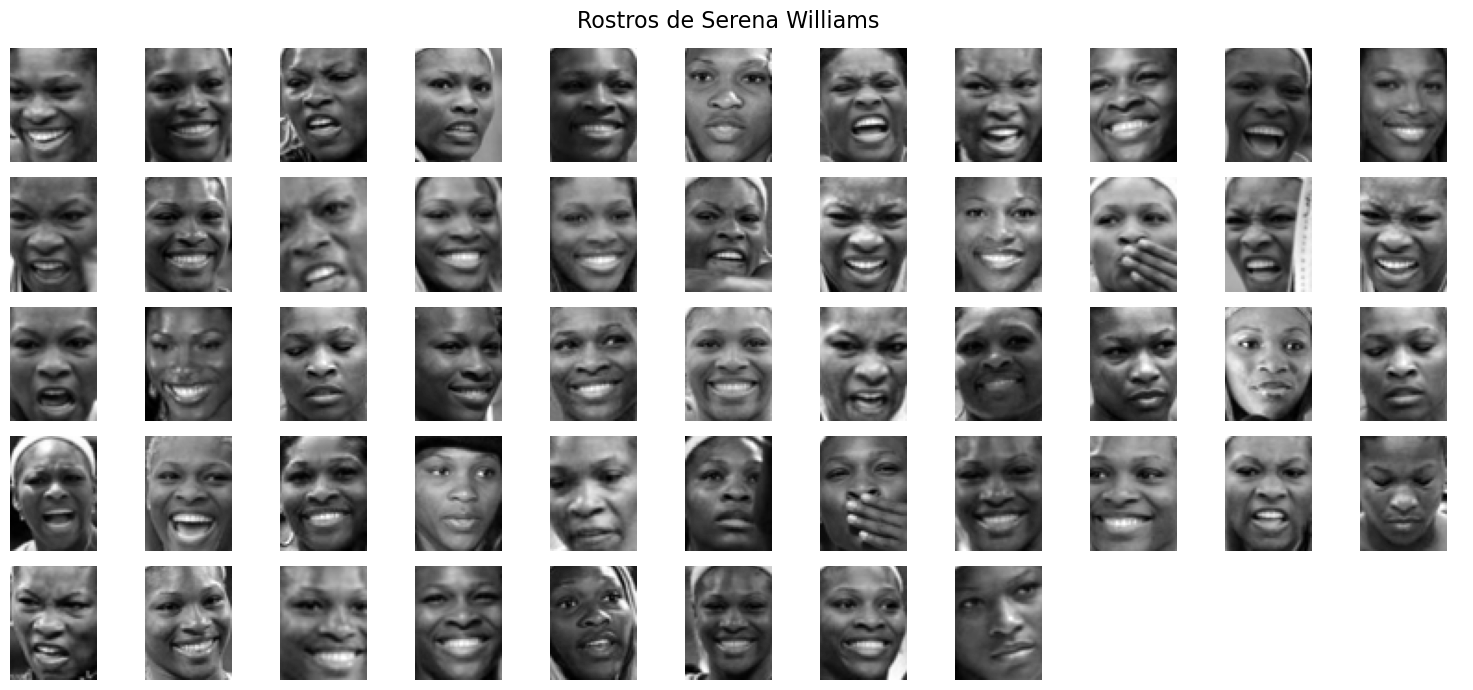

In [9]:
# nuevo array con las imagenes de interes 
df_imagen_filtrada = df_images[df_images["target_name"] == nombre].drop(columns=["target","target_name"])

# cantidad de imagenes
num_images = len(df_imagen_filtrada)

# Determinar el tamaño del grid de imagenes
rows = 5
cols = int(np.ceil(num_images/rows))

fig, axes = plt.subplots(rows, cols, figsize=(15, 7))
axes = axes.flatten()

# loop desde 0 hasta le tamaño de las imagenes filtradas
for i in np.arange(df_imagen_filtrada.shape[0]):

    # graficando la iamgen i
    ax = axes[i]
    ax.imshow(df_imagen_filtrada.iloc[i].to_numpy().reshape(h,w), cmap='gray') 
    # eliminar axis
    ax.axis('off')  

# eliminar axis de las imagenes vacias
for j in range(i + 1, rows * cols):
    axes[j].axis('off')

fig.suptitle("Rostros de {n}".format(n=nombre), fontsize=16)
plt.tight_layout()
plt.show()

### 3.  Reconociendo rostros: las eigenfaces

Las eigenfaces son un conjunto de eigenvectors utilizados en el campo de la visión por computadora, principalmente en el reconocimiento de rostros. Son el resultado de reducir la dimensión de un gran conjunto de imágenes faciales, manteniendo la información que es más relevante para diferenciar las caras.

En este apartado buscaremos encontrar el espacio de menor dimensión manteniendo la información que es más relevante para diferenciar las caras. Lo haremos en etapas:


#### 3.1. Rostro promedio. 

Encuentre primero el "rostro promedio" y grafíquelo.  Para encontrar este rostro, necesita calcular el valor promedio de los pixeles. (*Tip: Si X es la matriz donde las filas representan las imágenes  y en las columnas el tono de gris de los píxeles, debería calcular el promedio para cada una de las columnas*).
 

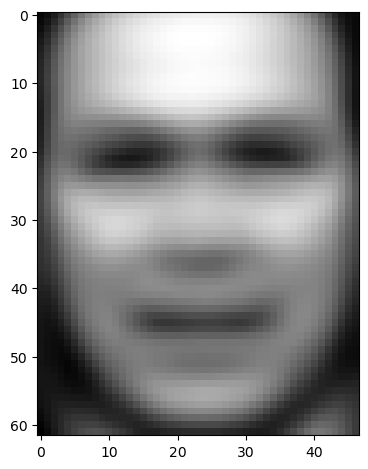

In [10]:
df_mean_face = df_images.drop(columns=["target","target_name"]).mean()
plt.imshow(df_mean_face.to_numpy().reshape(h,w), cmap='gray') 
plt.tight_layout()
plt.show()

El rostro promedio muestra que se identifican los ojos, nariz, boca y contorno de la cara. A partir de este tambien se puede decir que la mayoria de las fotos estan centradas en el rostro y que la mayoria de estas fotos son de frente, adicionalmente se evidencian lo que podrian ser rasgos masculinos por lo que tambien puede teorizarse que la mayotia de personas en este set de datos son hombres. 

A partir del analisis de frecuencia de fotos podremos interpretar que este rostro debe ser similar a **George W Bush** ya que es el quien tiene la mayor cantidad de fotos


#### 3.2. Reste el rostro promedio.

A cada una de las imágenes, reste el rostro promedio, es decir, reste la media a cada columna. Grafique las imágenes de Serena Williams luego de quitarle el rostro promedio.

In [11]:
nombre = "Serena Williams"
df_imagen_filtrada = df_images[df_images["target_name"] == nombre].drop(columns=["target","target_name"])
df_imagen_filtrada_mean = df_imagen_filtrada - df_mean_face

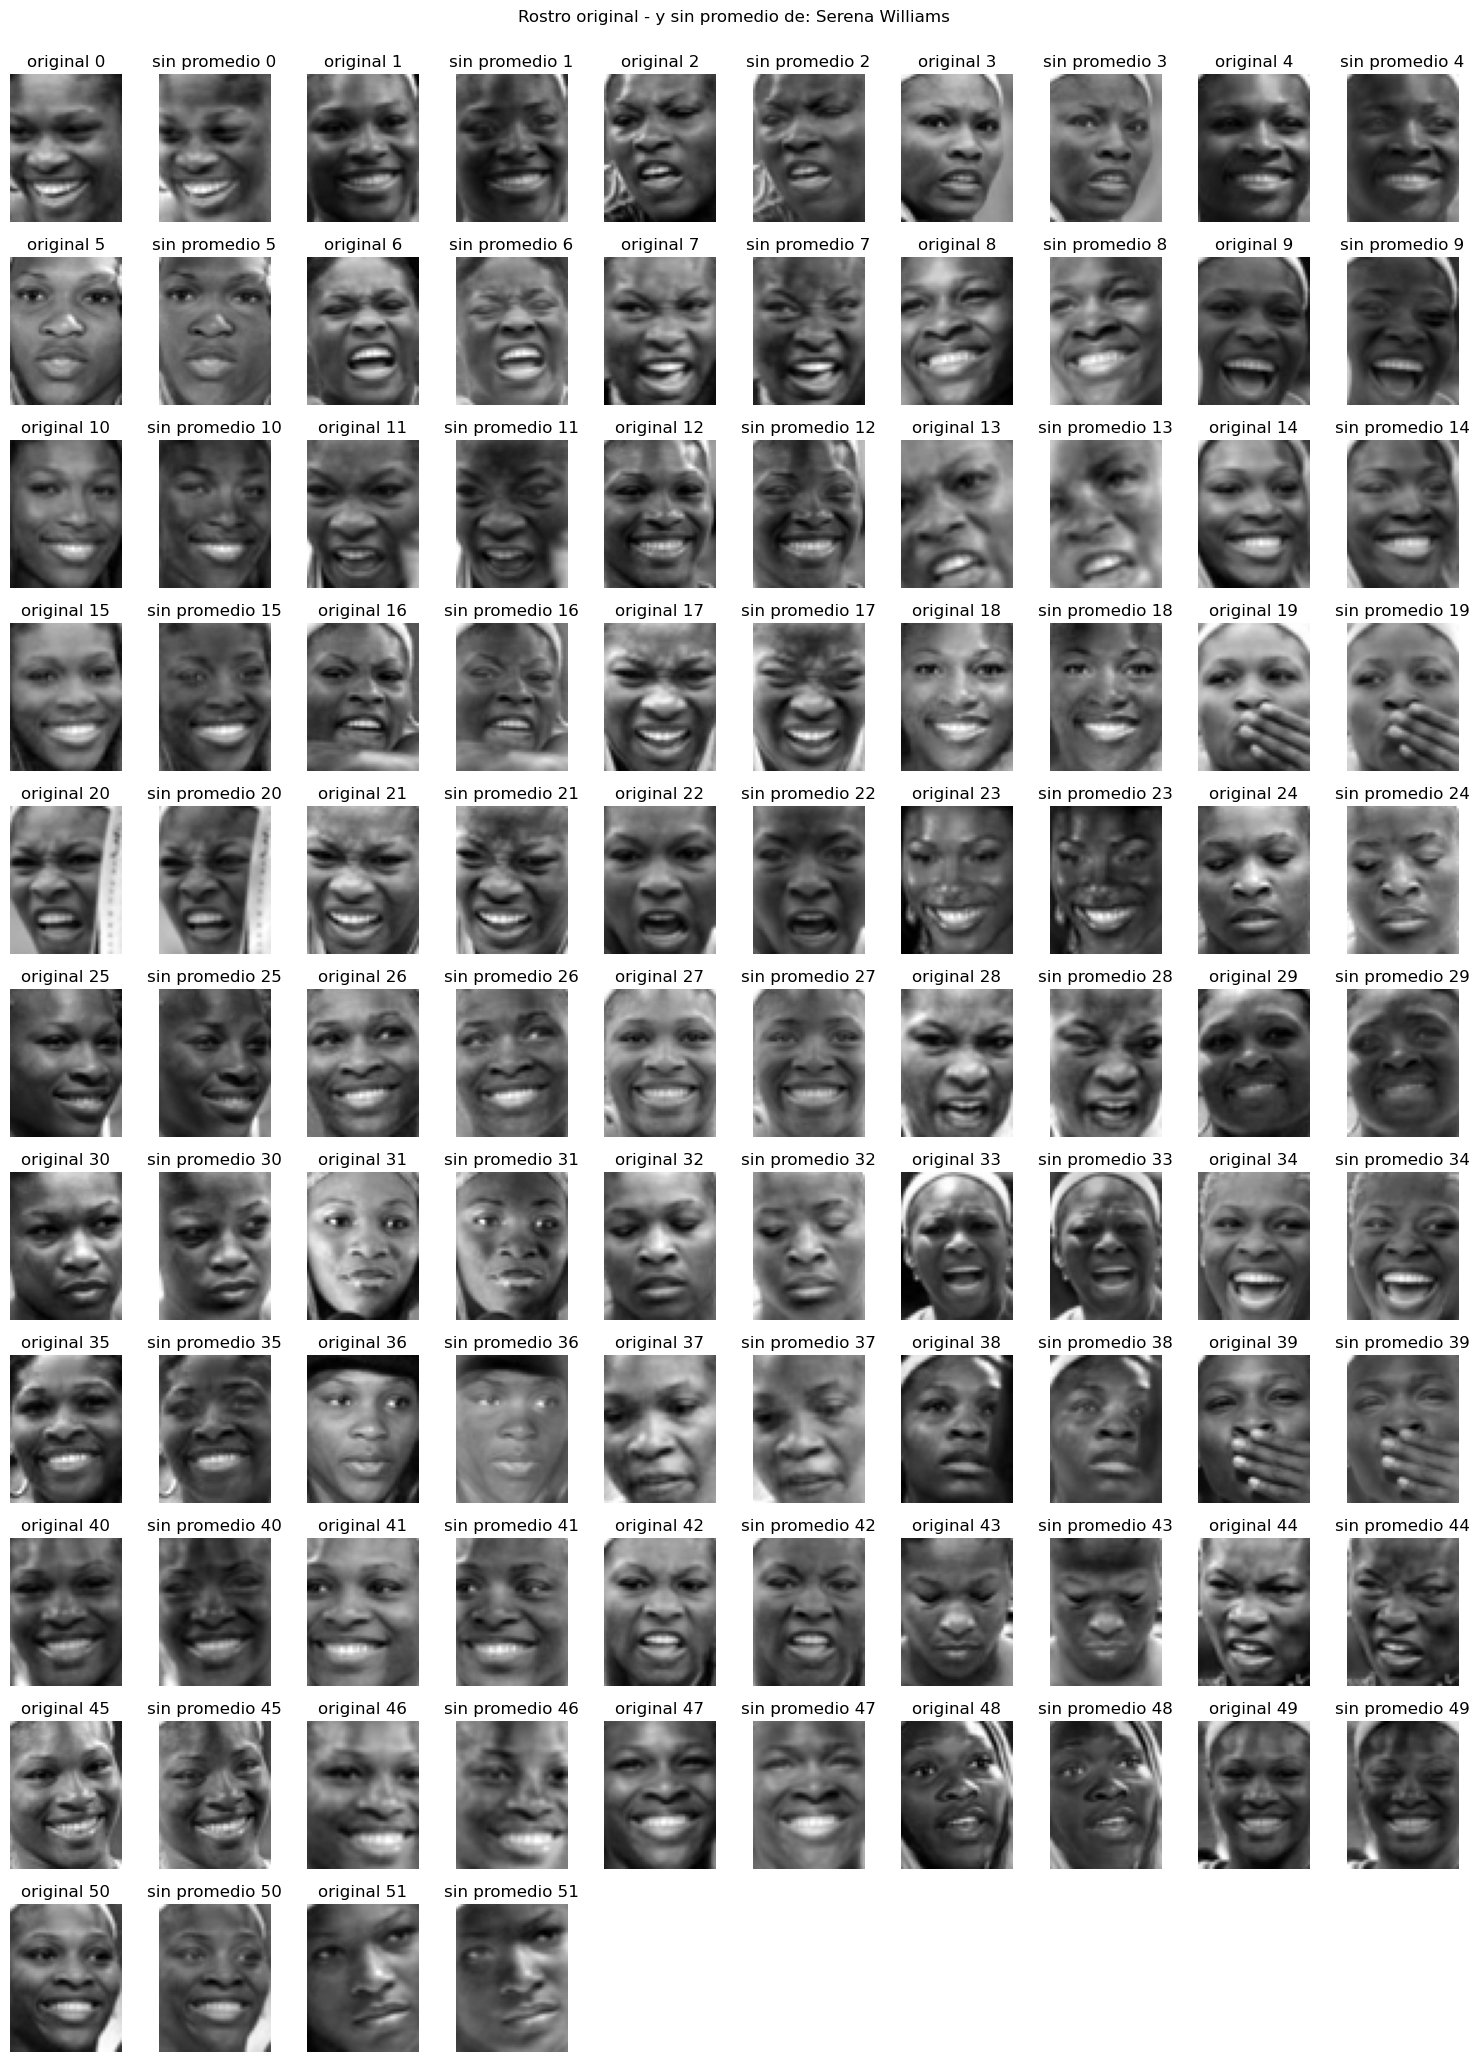

In [12]:
# cantidad de imagenes
num_images = len(df_imagen_filtrada_mean)

# Determinar el tamaño del grid de imagenes
cols = 10
rows = int(np.ceil((num_images*2)/cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 21))
axes = axes.flatten()

# loop desde 0 hasta le tamaño de las imagenes filtradas
for i in np.arange(df_imagen_filtrada_mean.shape[0]):

    # graficando la iamgen i
    ax = axes[i*2]
    ax.imshow(df_imagen_filtrada.iloc[i].to_numpy().reshape(h,w), cmap='gray') 
    # eliminar axis
    ax.axis('off')  
    ax.set_title("original {i}".format(i=i))


    # graficando la iamgen i
    ax = axes[(i*2)+1]
    ax.imshow(df_imagen_filtrada_mean.iloc[i].to_numpy().reshape(h,w), cmap='gray') 
    # eliminar axis
    ax.axis('off')  
    ax.set_title("sin promedio {i}".format(i=i))

# eliminar axis de las imagenes vacias
for j in range(i + 1, rows * cols):
    axes[j].axis('off')

fig.suptitle("Rostro original - y sin promedio de: {n}".format(n=nombre))
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Al restar el rostro promedio de las imagenes de Serena, se estan dejando los razgos carárcteristicos de ella, como la distancia entre los ojos, la distancia entre la nariz y la boca entre otros. con esta metodologia se tiene mayor exito en aquellas imagenes que son frontales, ya que el rostro promedio tiene esta configuracion

#### 3.3. Descomposición en Valores Singulares 

Aplique la Descomposición en Valores Singulares a estas nuevas imágenes y retenga solo $K=1000$ valores singulares? ¿Qué proporción de la varianza representan estos valores singulares?

In [13]:
df_imagen_mean = df_images.drop(columns=["target","target_name"]) - df_mean_face
U,S,Vt = svd(df_imagen_mean)

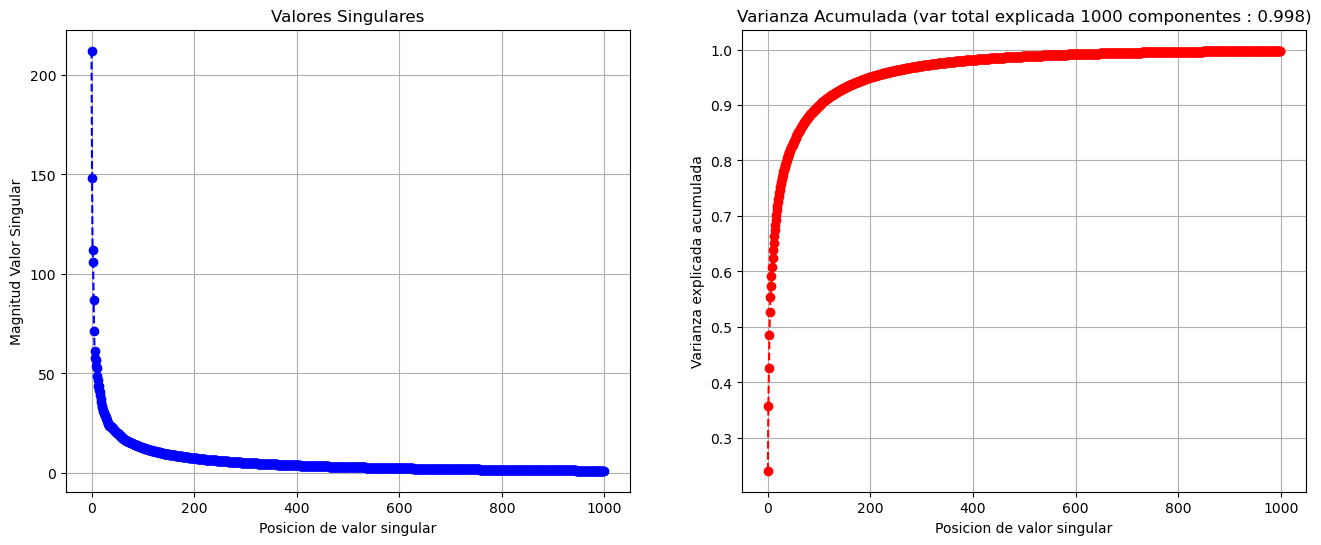

In [14]:
lim =1000

fig, ax = plt.subplots(1,2, figsize=(16,6))

# Opcional: Graficar los valores singulares
ax[0].plot(S[:lim], marker='o', linestyle='--', color='b')
ax[0].set_title('Valores Singulares')
ax[0].set_xlabel('Posicion de valor singular')
ax[0].set_ylabel('Magnitud Valor Singular')
ax[0].grid(True)

# encontrar la varianza explicada para los k valores singulares
idx = range(0,lim)
var_explained = S**2/np.sum(S**2)
cumsum=var_explained[0:lim].cumsum()
var_max = np.round(cumsum[-1],3)

ax[1].plot(idx,cumsum , color = 'r', marker='o', linestyle='--')
ax[1].set_title("Varianza Acumulada (var total explicada {k} componentes : {v:.3f})".format(k=lim, v = var_max))
ax[1].set_xlabel('Posicion de valor singular')
ax[1].set_ylabel('Varianza explicada acumulada')
ax[1].grid(True)

plt.show()

In [15]:
print("cantidad minima de valores singulares para explicar al 90 porciento de la varianza: {}".format(np.argmax(cumsum > 0.9)+1))

cantidad minima de valores singulares para explicar al 90 porciento de la varianza: 102


En las graficas anteirores se ve que con **1000** componentes se logra explicar el 99% de la varianza, incluso para explicar el 90% o mas se pueden tomar **101** valores, adicionalmente se ve que la magnitud de los valores singulares decrece sugnificativamente a partir de los primeros **200** valores

#### 3.4. Representando los rostros en las bases

Las eigenfaces nos dice que cada rostro puede ser representado a partir de la aproximación a la matriz original por la matriz de dimensión reducida (determinada en el punto anterior), más el rostro promedio. Muestre que esto es posible para las imágenes de Serena Williams. Compare las imágenes reconstruidas con las originales.

In [16]:
# Utilice este espacio para escribir el código.
S_diag= np.resize(S,[n,1])*np.eye(n,k) 

lim = 1000

df_reconstr = np.dot(U[:,0:lim],np.dot(S_diag[0:lim,0:lim],Vt[0:lim,:]))
df_reconstr = pd.DataFrame(df_reconstr)
df_reconstr = df_reconstr + df_mean_face
df_reconstr = df_reconstr.join(target)
df_reconstr["target_name"] = df_reconstr["target"].map(dict(enumerate(lfw_people["target_names"])))

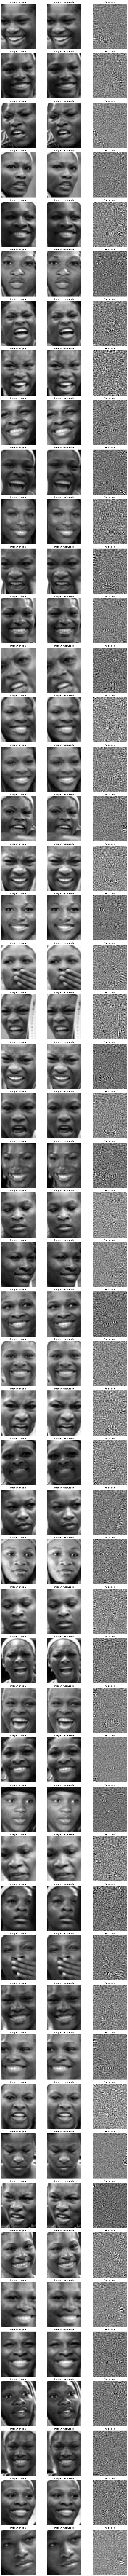

In [17]:
# nuevo array con las imagenes de interes 
df_imagen_filtrada_og = df_images[df_images["target_name"] == nombre].drop(columns=["target","target_name"])
df_imagen_filtrada_rest = df_reconstr[df_reconstr["target_name"] == nombre].drop(columns=["target","target_name"])

# cantidad de imagenes
num_images = len(df_imagen_filtrada_og)

# Determinar el tamaño del grid de imagenes
cols = 3
rows = num_images

fig, axes = plt.subplots(rows, cols,figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

# loop desde 0 hasta le tamaño de las imagenes filtradas
for i in np.arange(df_imagen_filtrada_og.shape[0]):
    # graficando la iamgen i
    ax = axes[i*3]
    ax.imshow(df_imagen_filtrada_og.iloc[i].to_numpy().reshape(h,w), cmap='gray') 
    # eliminar axis
    ax.set_title("imagen original")
    ax.axis('off')  

    ax = axes[(i*3)+1]
    ax.imshow(df_imagen_filtrada_rest.iloc[i].to_numpy().reshape(h,w), cmap='gray') 
    # eliminar axis
    ax.set_title("imagen restaurada")
    ax.axis('off')  

    ax = axes[(i*3)+2]
    df_rest = (df_imagen_filtrada_og.iloc[i] - df_imagen_filtrada_rest.iloc[i])
    ax.imshow(df_rest.to_numpy().reshape(h,w), cmap='gray') 
    # eliminar axis
    ax.set_title("Validacion")
    ax.axis('off')  

# eliminar axis de las imagenes vacias
for j in range(i + 1, rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

En las imagenes anteriores se logra ver que la reconstruccion a partir de los primeros 1000 valores singulares retorna una imagen "igual" a la original, para validar que razgos se perdieron al descartar el resto de valores singulares se reaalizo la resta de la matriz original y la matriz restaurada.

$$
    IMG_{original} - IMG_{restaurada} \approx 0
$$

si la restauracion fuese defectuosa y no lograse restaurar la imagen original en la tercera imagen deberiamos ver imagenes en donde se pueda identificar un rostro en éste caso en la gran mayoria se ve como si fuese un ruido blanco, por lo que no se estaria perdiendo informacion "valiosa" de la imagen

### 4. Uniendo Aprendizaje No Supervisado y Supervisado

Dado que cada rostro puede ser representado por las eigenfaces, y la relación que existe entre componentes principales y la SVD, esto sugiere que los componentes principales aquí determinados pueden servir de insumo para un algoritmo de clasificación de aprendizaje supervisado. En este sección del taller haremos esto.

Para ello construiremos un modelo de clasificación logístico para predecir si la imagen pertenece a `George W Bush`  (el individuo con más imágenes en la base)  o no.

#### 4.1. Identificando a `George W Bush`

Cree una variable binaria que tome el valor 1 si la imagen pertenece a `George W Bush` y 0 en caso contrario.

In [18]:
# Utilice este espacio para escribir el código.
nombre2 = "George W Bush"
df_images["y"] = (df_images["target_name"] == nombre2).astype(int)
df_images.head()

0         1         2         3         4         5         6  \
0  0.152941  0.193464  0.202614  0.236601  0.304575  0.384314  0.440523   
1  0.201307  0.214379  0.231373  0.256209  0.278431  0.300654  0.316340   
2  0.375163  0.380392  0.435294  0.586928  0.631373  0.636601  0.670588   
3  0.711111  0.707190  0.624837  0.465359  0.402614  0.430065  0.573856   
4  0.369935  0.443137  0.564706  0.641830  0.687582  0.667974  0.607843   

          7         8         9  ...      2907      2908      2909      2910  \
0  0.444444  0.431373  0.431373  ...  0.155556  0.160784  0.166013  0.173856   
1  0.339869  0.362092  0.385621  ...  0.932026  0.894118  0.887582  0.925490   
2  0.688889  0.687582  0.695425  ...  0.369935  0.070588  0.092810  0.083660   
3  0.670588  0.745098  0.759477  ...  0.467974  0.462745  0.479739  0.504575   
4  0.577778  0.537255  0.515033  ...  0.086275  0.096732  0.039216  0.062745   

       2911      2912      2913  target        target_name  y  
0  0.179085  0.183007  0.186928      10  Gerhard Schroeder  0  
1  0.909804  0.816993  0.631373       9      George W Bush  1  
2  0.091503  0.090196  0.090196      41     Vladimir Putin  0  
3  0.419608  0.107190  0.060131       6       Colin Powell  0  
4  0.070588  0.083660  0.078431       9      George W Bush  1  

[5 rows x 2917 columns]

Variable creada para identificar los casos positivos, que son aquellas imagenes que contienen el rostro de George W Bush

#### 4.2. Bases de Entrenamiento y Prueba.

Divida la base utilizada anteriormente en dos: 80% de la base de imágenes asígnelas a la base de entrenamiento y el 20% restante a la de prueba, utilice un `random_state=10101`. 

In [19]:
# Utilice este espacio para escribir el código.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_images.drop(columns=["target","target_name","y"]), df_images["y"], test_size=0.2, random_state=10101)


X_train = X_train - X_train.mean()
X_test = X_test - X_train.mean()

In [28]:
X_train.shape[1]

2914

In [29]:
print("Cantidad de imagenes en la base de entrenamiento {n}".format(n=X_train.shape[0]))
print("Cantidad de imagenes de George W Bush en la base de entrenamiento {n} ({p:.1f}%)".format(n=y_train.sum(), p=(y_train.sum()/X_train.shape[0])*100))

print("Cantidad de imagenes en la base de prueba {n}".format(n=X_test.shape[0]))
print("Cantidad de imagenes de George W Bush en la base de prueba {n} ({p:.1f}%)".format(n=y_test.sum(), p = (y_test.sum()/X_test.shape[0])*100))

Cantidad de imagenes en la base de entrenamiento 2070
Cantidad de imagenes de George W Bush en la base de entrenamiento 418 (20.2%)
Cantidad de imagenes en la base de prueba 518
Cantidad de imagenes de George W Bush en la base de prueba 112 (21.6%)


Quedan divididas las bases para aplicar las metodologías necesaria para el algoritmo de prediccion que será utilizado, adicionalmente se resta el rostro promeido de cada set de datos para que los datos tengan media 0 (como se solicita en el punto siguiente).

Las cantidad de imagenes para cada set son:

| **Dataset** | **Total imagenes** | **Pixeles** | **Imagenes de George Bush** | **Porcentaje de casos positivos** |
|-------------|--------------------|-------------|-----------------------------|-----------------------------------|
| **TRAIN**   | 2070               | 2914        | 418                         | 20.2%                             |
| **TEST**    | 5018               | 2914        | 112                         | 21.6%                             |

Las bases conservan su conportamiento con los casos positivos entre el 20 y 22 % de la base total


#### 4.3. Descomposición en Valores Singulares 

Para la base de entrenamiento y de prueba, realice la descomposición en valores singulares (Recuerde recentrar las matrices para que tenga media 0). 

In [30]:
from scipy.linalg import svd
U_train,S_train,Vt_train = svd(X_train)
U_test,S_test,Vt_test = svd(X_test)

Text(0, 0.5, 'Magnitud de Eigenvalues')

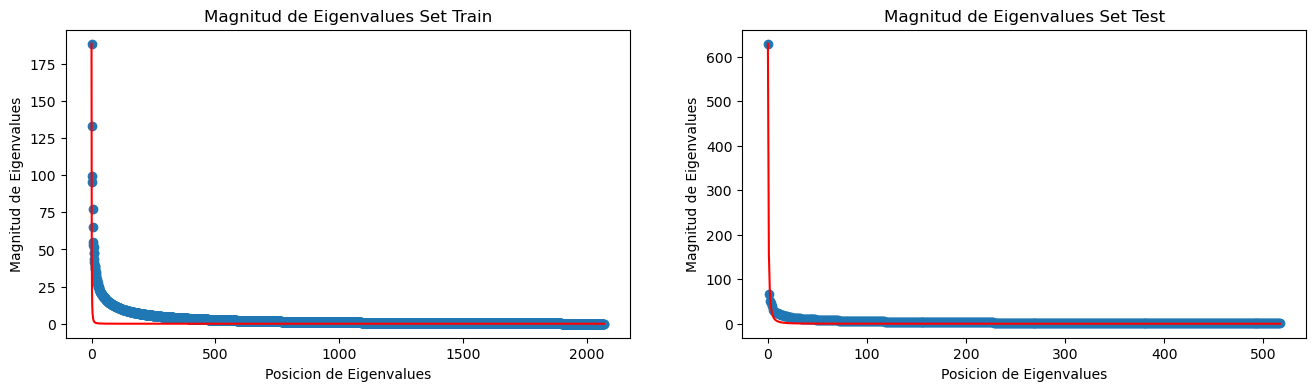

In [31]:
idx = range(len(S_train))
func = [S_train[0]/((i+1) ** 2) for i in idx ]


fig, ax = plt.subplots(1,2,figsize=(16, 4))

ax[0].plot(idx, func, color = 'r')
ax[0].scatter(idx, S_train)
ax[0].set_title("Magnitud de Eigenvalues Set Train")
ax[0].set_xlabel("Posicion de Eigenvalues")
ax[0].set_ylabel("Magnitud de Eigenvalues")

idx = range(len(S_test))
func = [S_test[0]/((i+1) ** 2) for i in idx ]

ax[1].plot(idx, func, color = 'r')
ax[1].scatter(idx, S_test)
ax[1].set_title("Magnitud de Eigenvalues Set Test")
ax[1].set_xlabel("Posicion de Eigenvalues")
ax[1].set_ylabel("Magnitud de Eigenvalues")

cantidad minima de valores singulares para explicar al 90 porciento de la varianza: 101
cantidad minima de valores singulares para explicar al 90 porciento de la varianza: 1


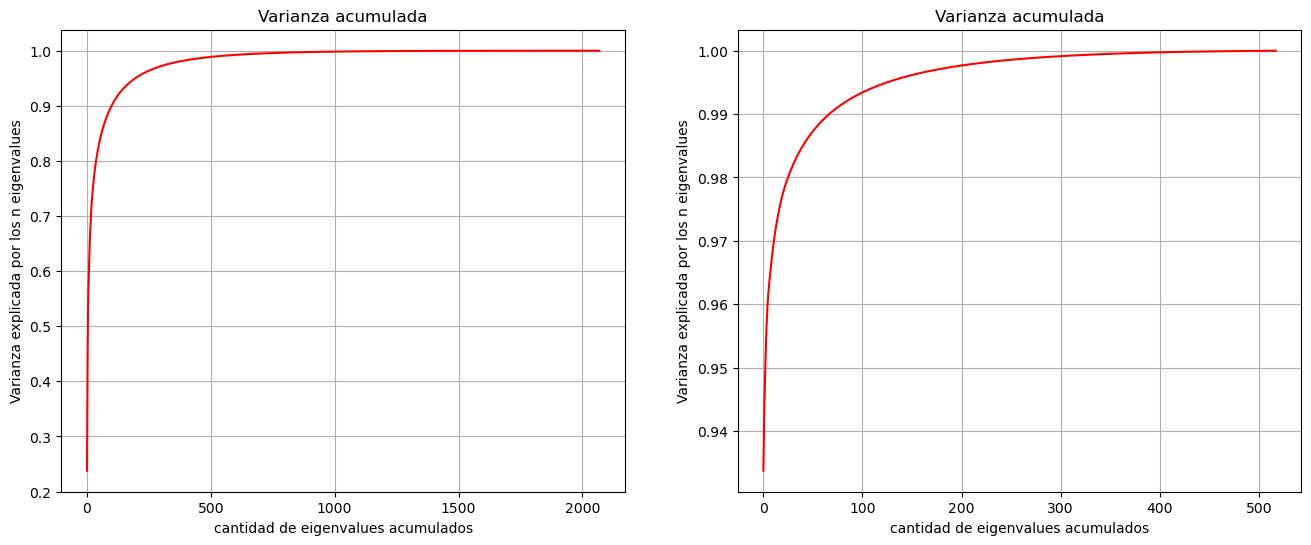

In [33]:
var_explained_train = np.round(S_train**2/np.sum(S_train**2), decimals=6)
cumsum_train = var_explained_train.cumsum()
idx = range(len(S_train))

print("cantidad minima de valores singulares para explicar al 90 porciento de la varianza: {}".format(np.argmax(cumsum_train > 0.9)+1))

fig, ax = plt.subplots(1,2,figsize=(16, 6))
#axs = ax.flatten()

ax[0].plot(idx,cumsum_train , color = 'r')
ax[0].set_title("Varianza acumulada")
ax[0].set_xlabel("cantidad de eigenvalues acumulados")
ax[0].set_ylabel("Varianza explicada por los n eigenvalues")
ax[0].grid(True)


var_explained_test = np.round(S_test**2/np.sum(S_test**2), decimals=6)
cumsum_test = var_explained_test.cumsum()
idx = range(len(S_test))

print("cantidad minima de valores singulares para explicar al 90 porciento de la varianza: {}".format(np.argmax(cumsum_test > 0.9)+1))

ax[1].plot(idx,cumsum_test , color = 'r')
ax[1].set_title("Varianza acumulada")
ax[1].set_xlabel("cantidad de eigenvalues acumulados")
ax[1].set_ylabel("Varianza explicada por los n eigenvalues")
ax[1].grid(True)

En las graficas anteriores se muestran las magnitudes de los eigenvalues y la varianza acumulada, estos guardan relacion directa con los valores singulares ya que $eigenvalues(X^T X) = S^2$

Adicionalmente la cantidad de eigenvalues difiere en ambos set de datos ya que la cantidad de valores singulares distintos de 0 estan dictaminados por el $min(n,k)$ donde $n$ y $k$ son las dimensiones de la matriz original de datos.

##### Train
- Este set tiene 2070 fiilas y 2914 columnas por lo que los valores singulares distintos de 0 serán: **2070**

- Para este set se necesitan almenos 101 valores singulares para explicar el 90% de la varianza o mas


##### Test
- Este set tiene 518 fiilas y 2914 columnas por lo que los valores singulares distintos de 0 serán: **518**

- Para este set se necesitan almenos 1 valor singulares para explicar el 90% de la varianza o mas, en este caso es tan reducida la cantidad de valores por que la dimension es menor como se eenuncio en la parte anterior

#### 4.4. Estimación de modelo de aprendizaje supervisado


Utilizando $k=1000$ valores singulares, construya los 1000 primeros componentes principales y úselos como predictores en su modelo logístico. Utilice como métrica de performance el porcentaje de imágenes de `George W Bush` clasificadas correctamente.

Para estimar su modelo logístico utilice el `solver='sag`,`random_state=10101` y `max_iter=1000`. Como se muestra a continuación:



In [34]:
def svd_trunc(X,lim):
    U,S,Vt = svd(X)
    n,k=X.shape

    S2= np.resize(S,[n,1])*np.eye(n,k)

    reconstructed=np.dot(U[:,0:lim],np.dot(S2[0:lim,0:lim],Vt[0:lim,:]))
    reconstructed = pd.DataFrame(reconstructed)
    return reconstructed

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score

Modelo_Logistico = LogisticRegression(solver='sag',random_state=10101,max_iter=1000)

X_red = svd_trunc(X_train,1000)
Modelo_Logistico.fit(X_red,y_train)

X_red_test = svd_trunc(X_test,1000)
y_pred = Modelo_Logistico.predict(X_red_test)

roc = roc_auc_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test, y_pred)

print("Precision obtenida por el modelo con 1000 valores singulares: {p}".format(p=np.round(precision,4)))
print("Recall obtenida por el modelo con 1000 valores singulares: {p}".format(p=np.round(recall,4)))

Precision obtenida por el modelo con 1000 valores singulares: 0.8241
Recall obtenida por el modelo con 1000 valores singulares: 0.7946


Manteniendo **1000** componentes principales se logra tener una prediccion cercana al **80%** adicionalmente de la seccion anterior sabemos que si se tienen más de **101** valores singulares se logra explicar mas del **90%** de la varianza. Tambien se obtiene la medida de precision del modelo que es superior al **80%**.  En principio este modelo puede considerarse con un buen desempeño en la identificacion de imagenes con el rostro de George W Bush

#### 4.5. Mejorando el Ajuste

Trate ahora el número de valores singulares como un hiper-parámetro a encontrar. Emplee validación cruzada con 5 o 10 folds (dependiendo de su poder computacional) para encontrar el número óptimo de valores singulares. Con este modelo, evalúe el porcentaje de imágenes de `George W Bush` clasificadas correctamente en su muestra de prueba. Compare y discuta esta forma de elegir el número de variables con aquella utilizada en  4.4. (Esto puede tomar mucho tiempo y requerir mucha capacidad computacional, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))


In [46]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

arr_limitaciones = list(np.arange(100,min(X_train.shape), 1000))
arr_limitaciones = np.round(np.logspace(-3, 0, num=30)*min(X_train.shape),0).astype(int)
# Se añade el numero de valores singulares que describen el 90% o mas identificado en las celdas anteriores
arr_limitaciones = np.append(arr_limitaciones, [102])

arr_limitaciones = np.sort(list(set(arr_limitaciones)))

In [81]:
arr_roc = []
arr_precision = []
arr_recall = []


for i,lm in enumerate(arr_limitaciones):
    
    print("inicio proceso {k} componentes".format(k=lm))
    
    X_new = svd_trunc(X_train,lm)
    X_new_test = svd_trunc(X_test,lm)

    # Entrenamiento del modelo
    Modelo_Logistico.fit(X_new,y_train)

    # Prediccion con set de test
    y_pred = Modelo_Logistico.predict(X_new_test)
    
    # Metricas
    roc = roc_auc_score(y_test,y_pred)
    arr_roc.append(roc)
    precision = precision_score(y_test,y_pred)
    arr_precision.append(precision)
    recall = recall_score(y_test,y_pred)
    arr_recall.append(recall)

inicio proceso 2 componentes
inicio proceso 3 componentes
inicio proceso 4 componentes
inicio proceso 5 componentes
inicio proceso 7 componentes
inicio proceso 9 componentes
inicio proceso 11 componentes
inicio proceso 14 componentes
inicio proceso 18 componentes
inicio proceso 22 componentes
inicio proceso 28 componentes
inicio proceso 36 componentes
inicio proceso 46 componentes
inicio proceso 58 componentes
inicio proceso 74 componentes
inicio proceso 94 componentes
inicio proceso 102 componentes
inicio proceso 119 componentes
inicio proceso 151 componentes
inicio proceso 191 componentes
inicio proceso 243 componentes
inicio proceso 308 componentes
inicio proceso 391 componentes
inicio proceso 496 componentes
inicio proceso 629 componentes
inicio proceso 798 componentes
inicio proceso 1013 componentes
inicio proceso 1286 componentes
inicio proceso 1631 componentes
inicio proceso 2070 componentes


inicio proceso 2 componentes
inicio proceso 3 componentes
inicio proceso 4 componentes
inicio proceso 5 componentes
inicio proceso 7 componentes
inicio proceso 9 componentes
inicio proceso 11 componentes
inicio proceso 14 componentes
inicio proceso 18 componentes
inicio proceso 22 componentes
inicio proceso 28 componentes
inicio proceso 36 componentes
inicio proceso 46 componentes
inicio proceso 58 componentes
inicio proceso 74 componentes
inicio proceso 94 componentes
inicio proceso 102 componentes
inicio proceso 119 componentes
inicio proceso 151 componentes
inicio proceso 191 componentes
inicio proceso 243 componentes
inicio proceso 308 componentes
inicio proceso 391 componentes
inicio proceso 496 componentes
inicio proceso 629 componentes
inicio proceso 798 componentes
inicio proceso 1013 componentes
inicio proceso 1286 componentes
inicio proceso 1631 componentes
inicio proceso 2070 componentes


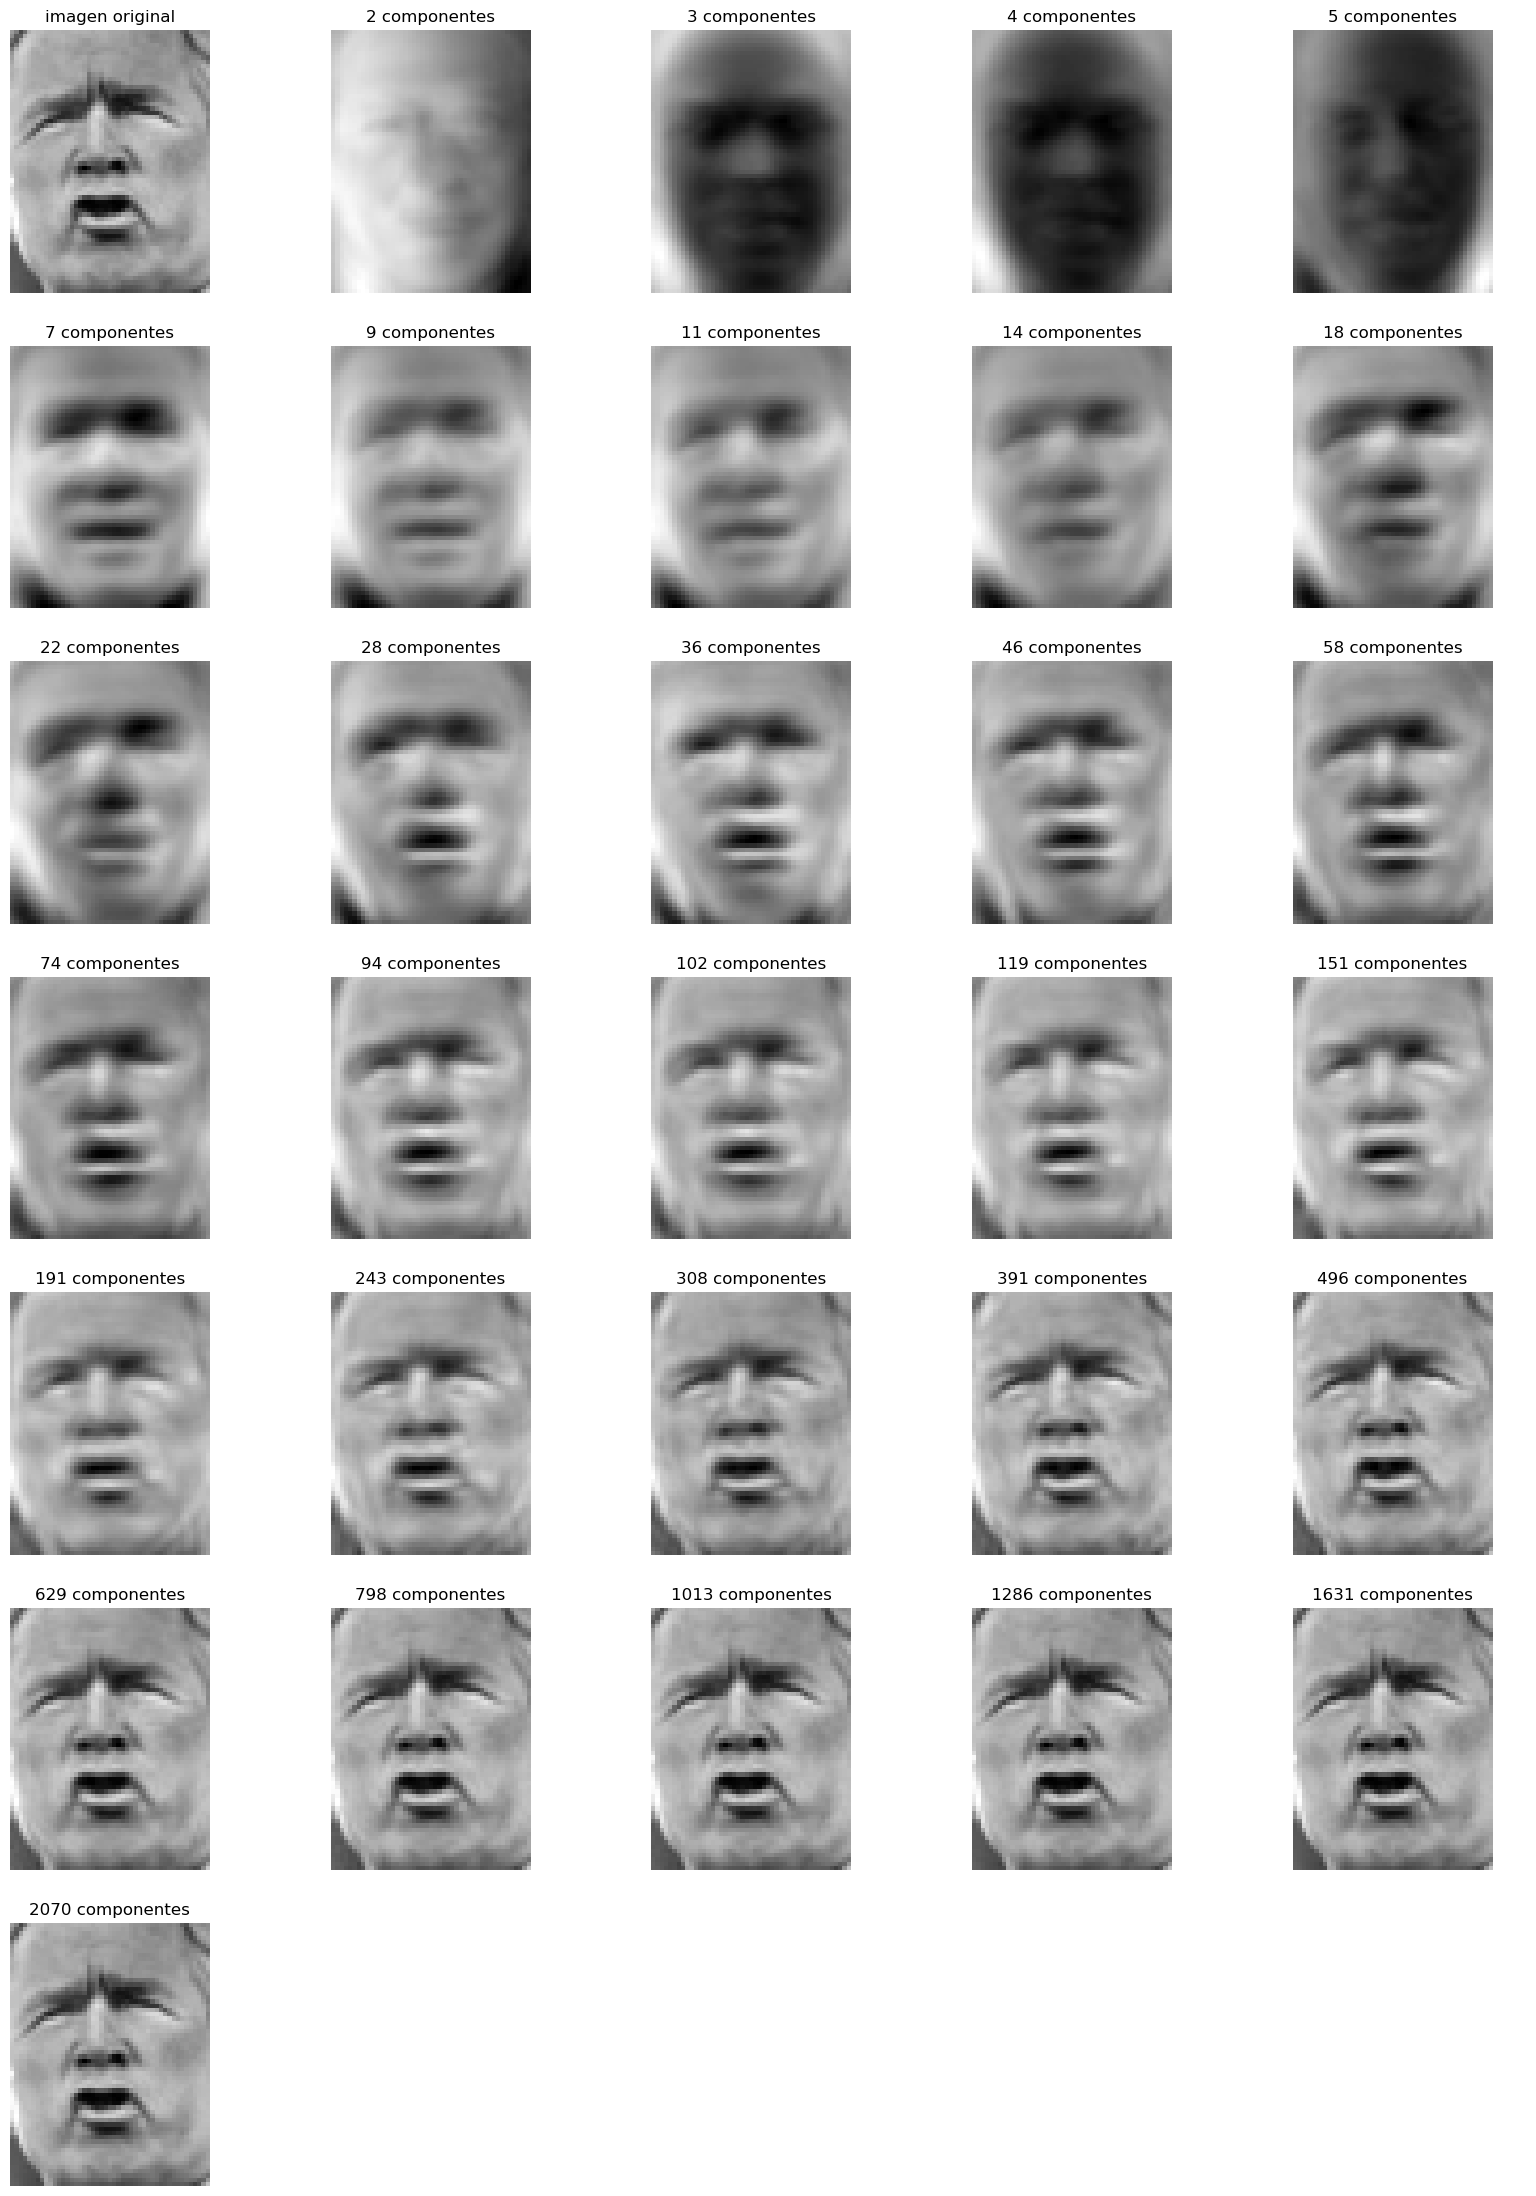

In [48]:
from sklearn.model_selection import cross_val_score, KFold


cols = min(5,len(arr_limitaciones)+1)
rows = int(np.ceil( (len(arr_limitaciones)+1)/cols))

fig, axes = plt.subplots(rows,cols,figsize=(4 * cols, 4 * rows))
ax = axes.flatten()

# Plot Imagen Original
ubicacion = np.where(y_train==1)[0][0]
arr_image = X_train.iloc[ubicacion,:]
ax[0].imshow(arr_image.to_numpy().reshape(h,w), cmap='gray') 
ax[0].set_title("imagen original")
ax[0].axis('off')  


arr_cv_results = []
for i,lm in enumerate(arr_limitaciones):
    
    print("inicio proceso {k} componentes".format(k=lm))
    
    X_new_train = svd_trunc(X_train,lm)

    Modelo_Logistico = LogisticRegression(solver='sag',random_state=10101,max_iter=1000)
    scores = cross_val_score(Modelo_Logistico, X_new_train, y_train, cv=5, scoring='recall')

    
    arr_cv_results.append((lm, np.mean(scores)))
    

    # Demostracion de una imagen con reduccion de componentes
    new_image = X_new_train.iloc[ubicacion,:]

    ax[i+1].imshow(new_image.to_numpy().reshape(h,w), cmap='gray') 
    ax[i+1].set_title("{k} componentes".format(k=lm))
    ax[i+1].axis('off')  

    #print("fin proceso {k} componentes".format(k=lm))

for j in range(i + 2, rows * cols):
    ax[j].axis('off')

In [110]:
# obtener el indice del valor maximo obtenido de crossvalidation
i_max = np.argmax([t[1] for t in arr_cv_results])
# index del 90% de la varianza
idx_90 = np.where(np.array([t[0] for t in arr_cv_results])==102)[0][0]
i_max

25

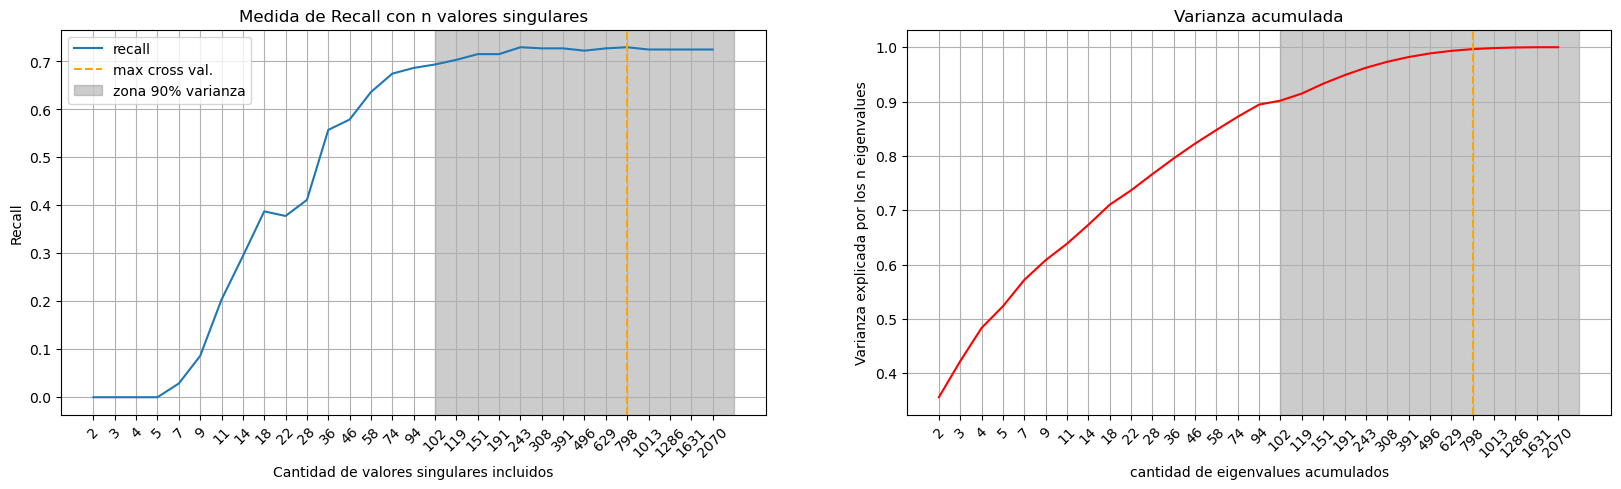

In [114]:
fig, axes = plt.subplots(1,2,figsize=(20,5))

ax = axes.flatten()


ax[0].plot([t[1] for t in arr_cv_results], label="recall")

ax[0].set_xticks(range(len([str(t[0]) for t in arr_cv_results])))
ax[0].set_xticklabels([str(t[0]) for t in arr_cv_results], rotation=45)

ax[0].axvline(i_max, linestyle = "--", color = "orange", label="max cross val.")
ax[0].axvspan(idx_90, len(arr_roc), color = "grey", alpha=0.4, label = "zona 90% varianza")

ax[0].set_title("Medida de Recall con n valores singulares")
ax[0].set_xlabel("Cantidad de valores singulares incluidos")
ax[0].set_ylabel("Recall")

ax[0].legend()
ax[0].grid(True)


# grafica de Varianza Explicada
ax[1].plot(cumsum_train[[t[0]-1 for t in arr_cv_results]] , color = 'r')

ax[1].set_xticks(range(len([str(t[0]) for t in arr_cv_results])))
ax[1].set_xticklabels([str(t[0]) for t in arr_cv_results], rotation=45)

ax[1].axvline(i_max, linestyle = "--", color = "orange", label="max cross val.")
ax[1].axvspan(idx_90, len(arr_roc), color = "grey", alpha=0.4, label = "zona 90% varianza")

ax[1].set_title("Varianza acumulada")
ax[1].set_xlabel("cantidad de eigenvalues acumulados")
ax[1].set_ylabel("Varianza explicada por los n eigenvalues")

ax[1].grid(True)


plt.show()

In [115]:
idx_max_roc = np.argmax(arr_roc)
idx_max_precision = np.argmax(arr_precision)
idx_max_recall = np.argmax(arr_recall)

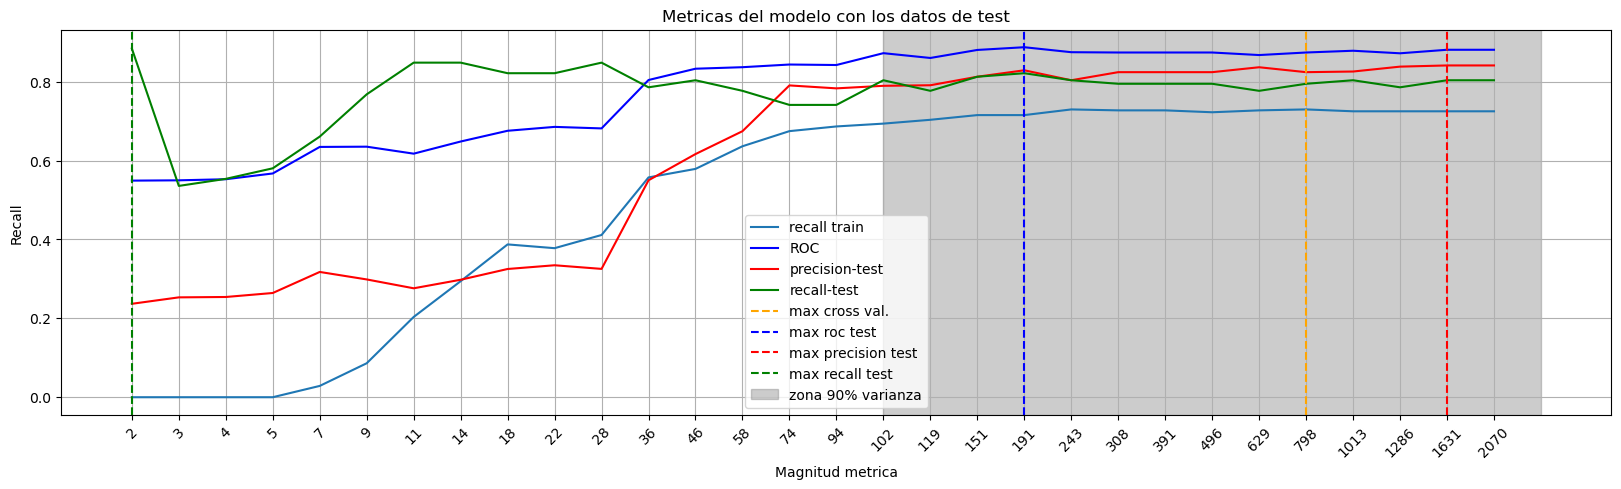

In [122]:
idx_90 = np.where(np.array([t[0] for t in arr_cv_results])==102)[0][0]

fig, axes = plt.subplots(figsize=(20,5))


axes.plot([t[1] for t in arr_cv_results], label="recall train")
axes.plot(arr_roc, label="ROC", c="b")
axes.plot(arr_precision, c="r", label="precision-test") 
axes.plot(arr_recall, c="g", label="recall-test") 

axes.set_xticks(range(len([str(t[0]) for t in arr_cv_results])))
axes.set_xticklabels([str(t[0]) for t in arr_cv_results], rotation=45)

axes.axvline(i_max, linestyle = "--", color = "orange", label="max cross val.")

axes.axvline(idx_max_roc, linestyle = "--", color = "b", label="max roc test")
axes.axvline(idx_max_precision, linestyle = "--", color = "r", label="max precision test")
axes.axvline(idx_max_recall, linestyle = "--", color = "g", label="max recall test")

axes.axvspan(idx_90, len(arr_roc), color = "grey", alpha=0.4, label = "zona 90% varianza")

axes.set_title("Metricas del modelo con los datos de test")
axes.set_xlabel("Magnitud metrica")
axes.set_ylabel("Recall")

axes.legend()
axes.grid(True)

En el proceso anterior se realizaron dos iteraciones de sobre los datos, la primera con el objetivo de recolectar las metricas de desempeño del modelo vs el set de entrenamiento, la segunda iteracion fue realizando el proceso de crossvalidation que en su interior toma el X_train y lo divide nuevamente en sets de train y test. Estas iteraciones se realizaron con el objetivo de evidenciar cual es el comportamiento real del modelo y su robustez.

Adicionalmente la forma en la que se iteró fue realizada en manera que los pesos fueran teniendo incrementos cada vez mas grandes entre ellos (exponencial), esto para ver el efecto que tiene la adicion de mas valores singulares en el calculo de la matriz de entrenamiento.


##### Conclusiones

Cuando se elige la mejor medida segun el método de crossvalidation se encuentra que la mejor medida de componentes principales es de $798$, esta cantidad de componentes principales logra explicar mas del 90% de la varianza según lo visto en los numerales anteriores.
Sin embargo cuando se miran las otras metricas del modelo respecto al set de entrenamiento se pueden argumentar diferentes puntos "optimos" de valores singulares, dependiendo de la metrica elegida. por ejemplo si la medida es el area bajo la curva ROC la cantidad adecuada de valores singulares es $191$ que es un valor que explica mas del 90% de la varianza. Los otros valores no se consideran ya que el maximo valor de recall en test esta por fuera de la zona de varianza explicada mayor al 90%; por otro lado el valor maximo de precision en set de test es el de mayor cantidad de valores singulares, por lo que podrian considerarse otros valores que aprovechen las bondades de reduccion de dimensionalidad.

Personalmente eligiria $191$ valores singulares, ya que como se ve en la gráfica recoje la matyor cantidad de bondades como son:

- Reduccion de dimensionalidad con explicacion de la varianza mayor a 90%
- Recall alto en train cercano al valor optimo identificado
- Metricas en el set test superiores al 80%